In [1]:
from rhana.pattern import *
from rhana.spectrum.spectrum import *
from rhana.labeler.unet import *
from functools import partial
from rhana.io.kashiwa import *

In [2]:
rd_paths = find_raw_rheed(Path("../data/raw/"))

In [3]:
import matplotlib.pyplot as plt
AOI05 = ~(plt.imread(str("../data/raw/maskIT005.png"))[:, :, 3].astype(bool))
AOI03 = np.zeros((600, 800), dtype=bool)
AOI03[50:, 60:-60] = True

In [5]:
def get_rheed(path, experiment_label, config=None, nomask=False):
    if experiment_label == "IT004":
        return Rheed.from_kashiwa(path, contain_hw=False, log=False, min_max_scale=True, standard_norm=False, config=config, )
    elif experiment_label == "IT003":
        return Rheed.from_image(path, rotate=-2, min_max_scale=True, standard_norm=False, AOI=AOI03, config=config)
    elif experiment_label == "IT005":
        return Rheed.from_image(path, min_max_scale=True, standard_norm=False, AOI=AOI05, config=config)
    else:
        return Rheed.from_kashiwa(path, contain_hw=True, log=False, min_max_scale=True, standard_norm=False , config=config)

In [24]:
lastentries = { k : v[-1] if len(v)>0 else None for k,v in rd_paths.items() }
lastrds = {}

for k, v in lastentries.items():    
    rd = get_rheed(v, k)
    rd = rd.mean_clip().min_max_scale()
    lastrds[k] = rd

In [25]:
lastrds['IT022'] = get_rheed(rd_paths['IT022'][-100], 'IT022').mean_clip().min_max_scale()

In [ ]:
ls

In [10]:
from skimage.transform import rescale, resize, downscale_local_mean

In [16]:
reference_value = cali_exp_pixel_real['IT006']

In [19]:
ch, cw = 400, 400

In [20]:
for name, rd in lastrds.items():
    scale = cali_exp_pixel_real[name]/reference_value    
    pattern = rescale(rd.pattern, cali_exp_pixel_real[name]/reference_value)
    h,w = pattern.shape
    oh, ow = rd.pattern.shape    
    pattern = pattern[:ch, int(w/2)-(cw//2):int(w/2)+(cw//2)]
    rd.pattern = pattern

In [8]:
save_folder = Path("publication/RHEED")
save_folder.mkdir(exist_ok=True)

In [23]:
from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
masker = UnetMasker("../learner/UNet_May6_2021_fixed.pkl")

In [31]:
offset = -20
window_width = 500
window_height = 400

In [54]:
shifts = defaultdict(lambda : 0)
shifts.update({
    'IT009' : 20,
    'IT014' : 20,
    'IT028' : 20,
    'IT021' : -30,
    'IT017' : 40,
    'IT024' : 0,
    'IT023' : 20,
})

IT013 0


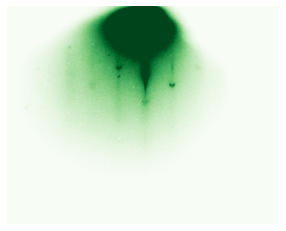

IT020 0


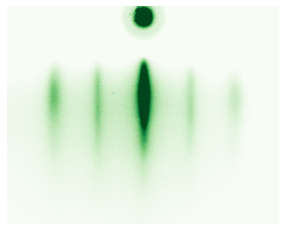

IT007 0


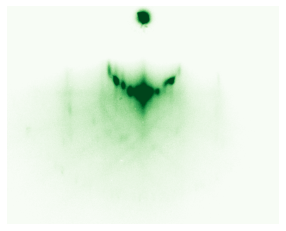

IT016 0


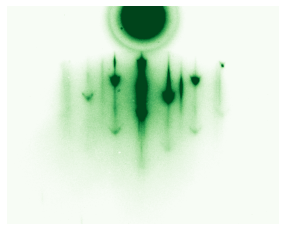

IT027 0


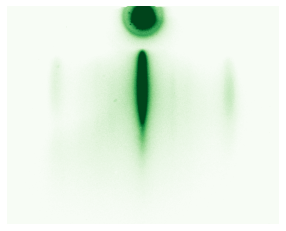

IT023 20


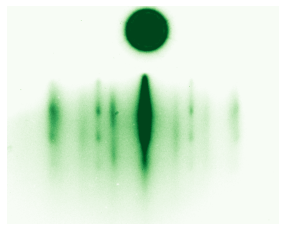

IT018 0


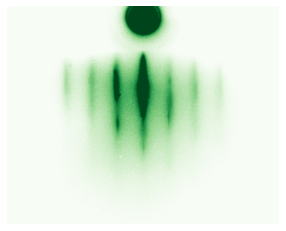

IT025 0


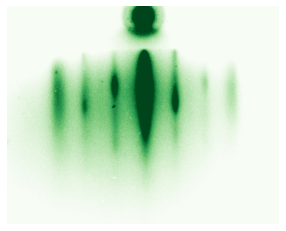

IT017 40


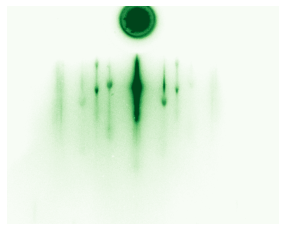

IT008 0


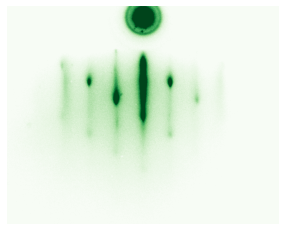

IT024 0


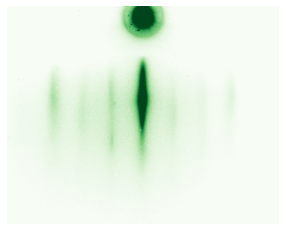

IT021 -30


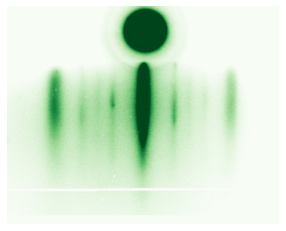

IT012 0


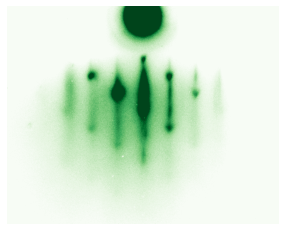

IT030 0


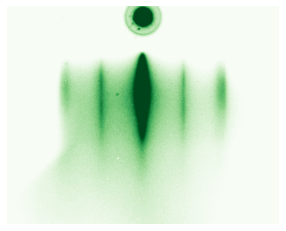

IT010 0


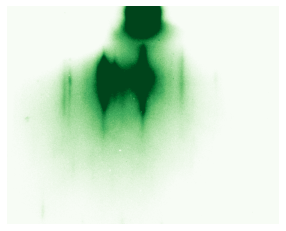

IT005 0


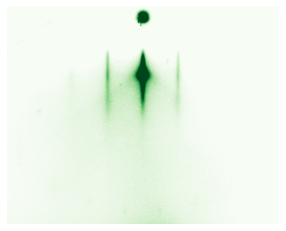

IT009 20


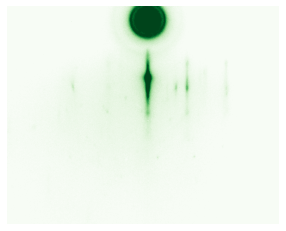

IT006 0


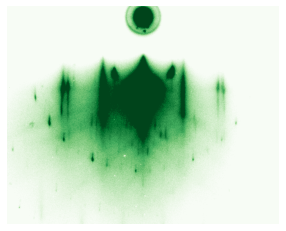

IT022 0


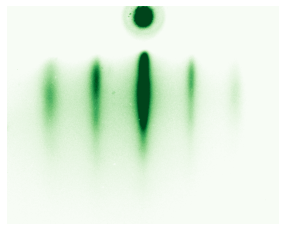

IT029 0


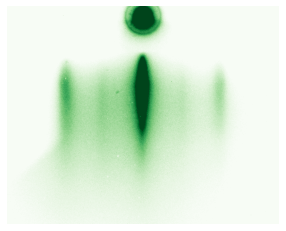

IT015 0


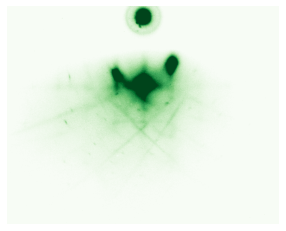

IT003 0


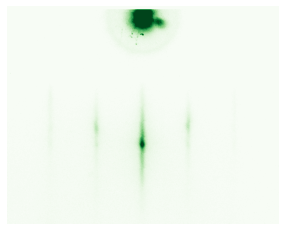

IT014 20


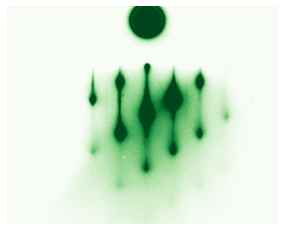

IT028 20


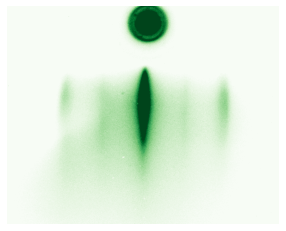

IT011 0


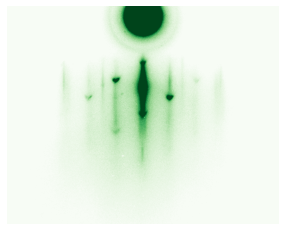

IT004 0


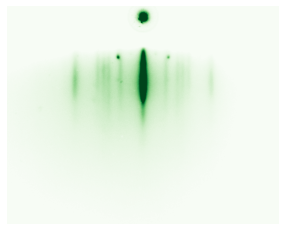

In [57]:
crop_rds = {}
for name, rd in lastrds.items():
    masks = masker.predict(rd)
    rdm_streak = RheedMask(rd, masks['streak'])
    rdm_spot = RheedMask(rd, masks['spot'])

    # rdm_streak.get_regions(with_intensity=True)
    # rdm_streak.filter_regions(min_area=10)
    rdm_spot.get_regions(with_intensity=True)
    rdm_spot.filter_regions(min_area=120)

    db, r_i, _ = rdm_spot.get_direct_beam()

    db = (round(db[0]), round(db[1]))

    print(name, shifts[name])
    sx = db[0] + offset 
    sy = db[1] - window_width//2 + shifts[name]
    ex = db[0] + offset + window_height 
    ey = db[1] + window_width//2 + shifts[name]

    cr_rdm_spot = rdm_spot.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)
    cr_rdm_streak = rdm_streak.crop(sx=sx, sy=sy, ex=ex, ey=ey, inplace=False)
    
    crop_rds[name] = cr_rdm_spot.rd

    # rdm_spot.plot_regions()
#     fig, ax = cr_rdm_spot.rd.plot_pattern()
    cr_rdm_spot.rd.pattern = np.clip(cr_rdm_spot.rd.pattern, 0, 0.3)
    fig, ax = cr_rdm_spot.rd.plot_pattern(cmap='Greens')
#     ax.set_title(name)  
    ax.set_axis_off()
    p = -int(np.log10(cali_exp_cons[name][0]))
    T = cali_exp_cons[name][1]        
    fig.savefig(save_folder/f"{p}-{T}-{name}.png", dpi=100, pad_inches=0,bbox_inches='tight')
    plt.show()    
    plt.close(fig)    
